In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 10})
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_moons
# PyTorch
import torch

In [2]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import likelihoods
import losses
import priors
import utils

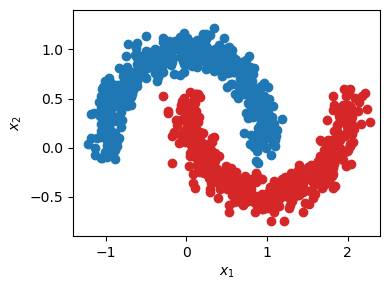

In [3]:
N = 1_000
X_numpy, y_numpy = make_moons(n_samples=N, noise=0.1, random_state=42)

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

X_train, X_val = X[:int((4/5)*N)], X[int((4/5)*N):]
y_train, y_val = y[:int((4/5)*N)], y[int((4/5)*N):]

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

ax.scatter(X_numpy[:,0][y_numpy==0], X_numpy[:,1][y_numpy==0], color="#1F77B4")
ax.scatter(X_numpy[:,0][y_numpy==1], X_numpy[:,1][y_numpy==1], color="#D62728")
ax.set_xlim([-1.4, 2.4])
ax.set_ylim([-0.9, 1.4])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.tight_layout()
plt.show()

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train.view(-1).long())
val_dataset = torch.utils.data.TensorDataset(X_val, y_val.view(-1).long())

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))


In [5]:
def train_one_epoch(model, criterion, optimizer, dataloader):
    
    model.train()
    
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        
        batch_size = len(X_batch)
        
        optimizer.zero_grad()
        params = utils.flatten_params(model)
        logits = model(X_batch)
        loss = criterion(logits, y_batch, params, len(dataloader.dataset))
        running_loss += (1 / batch_size) * loss.item()
        loss.backward()
        optimizer.step()
        
    return running_loss
        
def evaluate(model, criterion, dataloader):
    
    model.eval()
    
    with torch.no_grad():
        
        running_loss = 0.0
        for X_batch, y_batch in dataloader:

            batch_size = len(X_batch)
            
            params = utils.flatten_params(model)
            logits = model(X_batch)
            loss = criterion(logits, y_batch, params, len(dataloader.dataset))
            running_loss += (1 / batch_size) * loss.item()
            
    return running_loss


In [6]:
model = layers.RFFLaplace(in_features=2, out_features=2, rank=1024, lengthscale=0.25, outputscale=1.0)
likelihood = likelihoods.CategoricalLikelihood()
prior = priors.GaussianPrior()

map_criterion = losses.MAPLoss(likelihood, prior)
erm_criterion = losses.ERMLoss(likelihood)

state_dict = {
    "model": model.state_dict(),
    "likelihood": likelihood.state_dict(),
    "prior": prior.state_dict(),
}

best_val_loss = float("inf")
best_state_dict = None

for lr in [0.1, 0.01, 0.001, 0.0001]:

    model.load_state_dict(state_dict["model"])
    likelihood.load_state_dict(state_dict["likelihood"])
    prior.load_state_dict(state_dict["prior"])
    
    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=lr, weight_decay=0.0)
    
    epochs = 10_000
    
    for epoch in tqdm.tqdm(range(epochs)):
        
        train_loss = train_one_epoch(model, map_criterion, optimizer, train_dataloader)
        val_loss = evaluate(model, erm_criterion, val_dataloader)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = {
            "model": model.state_dict(),
            "likelihood": likelihood.state_dict(),
            "prior": prior.state_dict(),
        }
        
model.load_state_dict(best_state_dict["model"])
likelihood.load_state_dict(best_state_dict["likelihood"])
prior.load_state_dict(best_state_dict["prior"])


100%|██████████| 10000/10000 [02:26<00:00, 68.05it/s]


<All keys matched successfully>

In [7]:
with torch.no_grad():
    
    model.update_covariance_from_dataloader(train_dataloader)

    x1, x2 = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))
    grid = torch.tensor(np.c_[x1.ravel(), x2.ravel()], dtype=torch.float32)

    probs = model.predict_proba(grid, num_samples=10_000)[:,1].reshape(x1.shape)
    

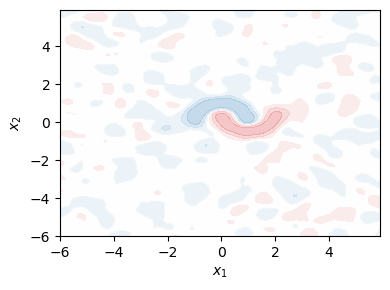

In [8]:
colors = ["#1F77B4", "#5799C7", "#8FBBDA", "#C7DDED", "#FFFFFF", "#F5C9CA", "#EB9394", "#E15D5E", "#D62728"]
cmap = LinearSegmentedColormap.from_list("bwr", colors)

x1, x2 = np.meshgrid(np.arange(-6, 6, 0.1), np.arange(-6, 6, 0.1))

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

#ax.scatter(X[:,0][y_numpy==0], X[:,1][y_numpy==0], color="#1F77B4")
#ax.scatter(X[:,0][y_numpy==1], X[:,1][y_numpy==1], color="#D62728")
ax.contourf(x1, x2, probs, alpha=0.3, cmap=cmap)
#ax.set_xlim([-1.4, 2.4])
#ax.set_ylim([-0.9, 1.4])
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.tight_layout()

plt.show()
